In [18]:
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm



sns.set_style('whitegrid')
template = 'seaborn'

In [19]:
# BASE_PATH = '/content/drive/MyDrive/Colab Notebooks'
BASE_PATH = './'
# BASE_PATH = './enhanced_dataset'

In [20]:
height, width = 160, 160

In [40]:
train = tf.keras.utils.image_dataset_from_directory(f"{BASE_PATH}/Training",
                                                    shuffle=True,
                                                    image_size=(height, width),
                                                    subset='training',
                                                    validation_split=0.2,
                                                    color_mode='rgb',
                                                    seed = 123,
                                                    batch_size=16,
                                                    )

validation = tf.keras.utils.image_dataset_from_directory(f"{BASE_PATH}/Testing",
                                                    shuffle=True,
                                                    image_size=(height, width),
                                                    subset='validation',
                                                    validation_split=0.2,
                                                    color_mode='rgb',
                                                    seed = 123,
                                                    batch_size=16,
                                                    )

# test = tf.keras.utils.image_dataset_from_directory(f"{BASE_PATH}/Testing",
#                                                     shuffle=True,
#                                                     image_size=(height, width),
#                                                     color_mode='rgb', 
#                                                     seed = 123,
#                                                     batch_size=16,
#                                                     )

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 1311 files belonging to 4 classes.
Using 262 files for validation.
Found 1311 files belonging to 4 classes.


In [22]:
num_classes = len(train.class_names)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomBrightness(0.2),
])

In [25]:
# model = keras.models.Sequential([
#     # keras.layers.Rescaling(1./255),
#     # data_augmentation,
#     keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(height, width, 3)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.8),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.8),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
model = keras.models.Sequential([
    # keras.layers.Rescaling(1./255),
    # data_augmentation,
    keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(height, width, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.8),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
history = model.fit(
                    train,
                    validation_data=validation,
                    epochs=10,
                    batch_size=16
                  )

Epoch 1/10


2024-05-05 12:07:30.388919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


286/286 [==============================] - 17s 30ms/step - loss: 4.0235 - accuracy: 0.5114 - val_loss: 1.8540 - val_accuracy: 0.6489
Epoch 2/10
286/286 [==============================] - 8s 27ms/step - loss: 1.7886 - accuracy: 0.7600 - val_loss: 1.6509 - val_accuracy: 0.7634
Epoch 3/10
286/286 [==============================] - 8s 27ms/step - loss: 1.2613 - accuracy: 0.8212 - val_loss: 1.1615 - val_accuracy: 0.8015
Epoch 4/10
286/286 [==============================] - 8s 28ms/step - loss: 1.0106 - accuracy: 0.8492 - val_loss: 0.8581 - val_accuracy: 0.8779
Epoch 5/10
286/286 [==============================] - 8s 29ms/step - loss: 0.7506 - accuracy: 0.8796 - val_loss: 0.6672 - val_accuracy: 0.8969
Epoch 6/10
286/286 [==============================] - 8s 28ms/step - loss: 0.5746 - accuracy: 0.9000 - val_loss: 0.6848 - val_accuracy: 0.9122
Epoch 7/10
286/286 [==============================] - 8s 28ms/step - loss: 0.4079 - accuracy: 0.9245 - val_loss: 0.5818 - val_accuracy: 0.9275
Epoch 8/1

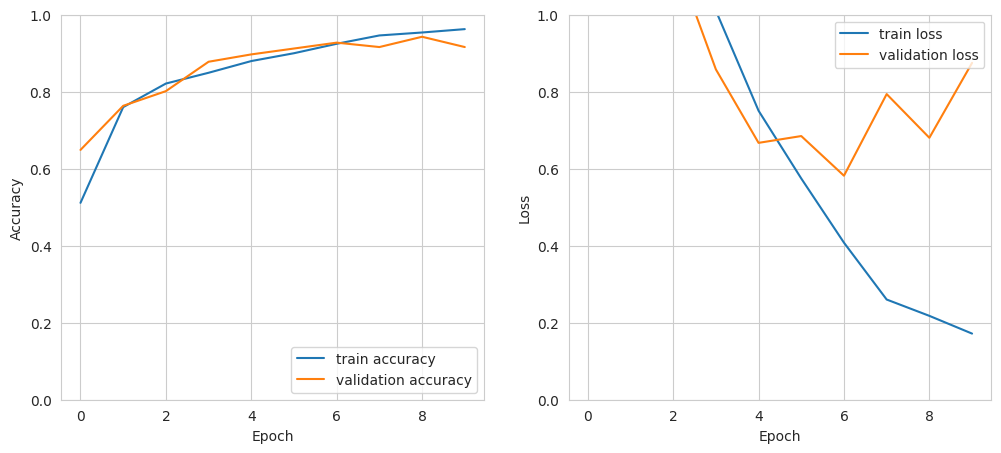

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'], label='train accuracy')
ax1.plot(history.history['val_accuracy'], label='validation accuracy')
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylim([0, 1])

ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='validation loss')
ax2.grid(True)
ax2.legend(loc='upper right')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 1])

plt.show()

In [29]:
def preprocessing_image(path: str, shape: Tuple[int, int], normalize: bool = False) -> np.ndarray:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if shape:
        image = cv2.resize(image, shape)
    if normalize:
        image = image/255
    return image

In [35]:
test = pd.read_csv(f'{BASE_PATH}/testing_data.csv', sep=";")
test_images = [preprocessing_image(f"{BASE_PATH}/{image}", shape=(height, width), normalize=False) for image in test['path']]
test_labels = test['class'].values
class_names = test['class_name'].unique()

In [36]:
test_loss, test_accuracy = model.evaluate(np.array(test_images), np.array(test_labels))
print(f"Test accuracy: {test_accuracy}")

41/41 [==============================] - 1s 11ms/step - loss: 0.6753 - accuracy: 0.9222
Test accuracy: 0.9221968054771423


In [37]:
y_pred = model.predict(np.array(test_images))
y_pred = np.argmax(y_pred, axis=1)

y_true = test_labels

conf_matrix = confusion_matrix(y_true, y_pred)

class_report = classification_report(y_true, y_pred, target_names=class_names)

print(class_report)


41/41 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

      glioma       1.00      0.81      0.90       300
  meningioma       0.83      0.88      0.85       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



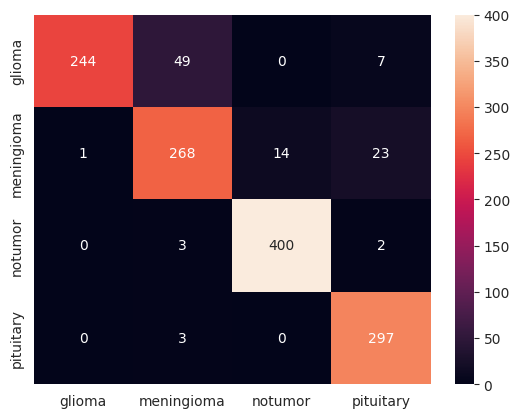

In [38]:
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.show()